# Pytorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* Ground Truth notebook - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb
* Book version of notebook - https://www.learnpytorch.io/01_pytorch_workflow/


In [ ]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [ ]:
import torch
from torch import nn ## nn contains all of pytorch's building blocks for neural netowrks
import matplotlib.pyplot as plt

# check PyTorch version
torch.__version__

'2.4.1+cu121'

## 1. Data (preparing and loading)

Data can be almost anything in ML.

* Excel spreadsheet
* Image of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:

1. Turn your data, whatever it is, into numbers (a representation).
2. Pick or build a model to learn the representation as best as possible.

But what if you don't have data?

Well, that's where we're at now.

No data.

But we can create some.

Let's create our data as a straight line.

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [ ]:
# create known parameters
weight = 0.7
bias = 0.3

# create 1000 data points with a range of 0 to 1
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets
We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose

For now, we'll just use a training and test set, this means we'll have a dataset for our model to learn on as well as be evaluated on.

We can create them by splitting our X and y tensors.



In [ ]:
len(X), len(y)

(50, 50)

In [ ]:
# Create a train test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visulize our data?

This is where the data explorer's motto comes in!

"Vizualize, Vizualize and vizualize!"

In [ ]:
def plot_predictions(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    # plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={'size': 14})

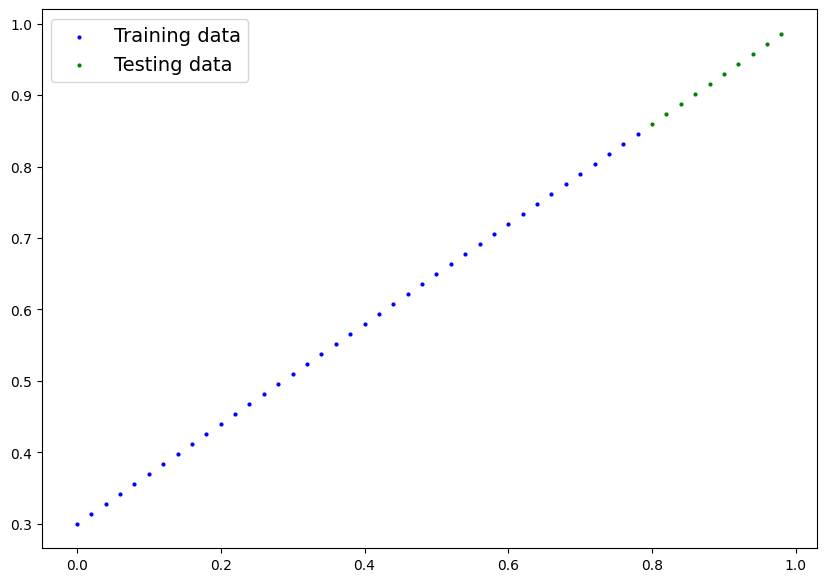

In [ ]:
plot_predictions()

## 2. Build model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

We're going to jump right in.

We'll write the code first and then explain everything.

Let's replicate a standard linear regression model using pure PyTorch.

What our model does:

* Start with random values (weight and bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal value we used to create the data

In [ ]:
# Create a linear regression model class
import torch
from torch import nn

class LinearRegressionModelV1(nn.Module): # almost everything in PyTorch inherits from nn.Module
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                requires_grad=True,
                                                dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias

### PyTorch model building essentials

PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are torch.nn, torch.optim, torch.utils.data.Dataset and torch.utils.data.DataLoader. For now, we'll focus on the first two and get to the other two later (though you may be able to guess what they do).

PyTorch module	What does it do?
1. torch.nn	- Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).

2. torch.nn.Parameter	 - Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".

3. torch.nn.Module - The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.

4. torch.optim - Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

5. def forward() - All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

### Checking the contents of our PyTorch model

Now we've created a model let's see what's inside .....

So we can check our model parameters using .parameters()

In [ ]:
# Create a random seed
torch.manual_seed(42)

# Create a linear regression model
model_0 = LinearRegressionModelV1()

# Check out the parameters
model_0.state_dict() , list(model_0.parameters())

(OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))]),
 [Parameter containing:
  tensor([0.3367], requires_grad=True),
  Parameter containing:
  tensor([0.1288], requires_grad=True)])

In [ ]:
# Actual parameters from our generated data
# we want to bring the random ones as close as possible to these
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`
To check this we can pass it the test data X_test to see how closely it predicts y_test.

When we pass data to our model, it'll go through the model's forward() method and produce a result using the computation we've defined.

Let's make some predictions.

In [ ]:
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds, y_test
# Note: in older PyTorch code you might also see torch.no_grad()
# but inference mode is faster and preferred
# with torch.no_grad():
#   y_preds = model_0(X_test)

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

You probably noticed we used torch.inference_mode() as a context manager (that's what the with torch.inference_mode(): is) to make the predictions.

As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

Note: In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred. See this Tweet from PyTorch for more.

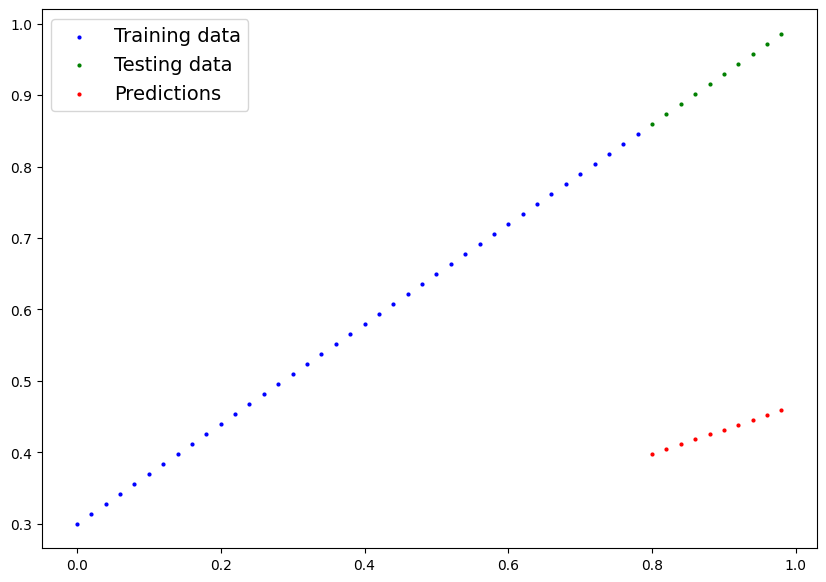

In [ ]:
plot_predictions(predictions=y_preds)

### 3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

We could hard code this (since we know the default values weight=0.7 and bias=0.3) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.


#### Creating a loss function and optimizer in PyTorch
For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.

The rolls of these are:

Function	What does it do?	Where does it live in PyTorch?	Common values
* **Loss function:**	Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better.	PyTorch has plenty of built-in loss functions in torch.nn.	Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). Binary cross entropy for binary classification problems (torch.nn.BCELoss()).
* **Optimizer:**	Tells your model how to update its internal parameters to best lower the loss.	You can find various optimization function implementations in torch.optim.	Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()).
Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under torch.nn.L1Loss()) in PyTorch as our loss function.

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

And specifically for PyTorch we need:

* A Training loop
* A Testing loop

In [ ]:
 # Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Building a Training Loop(and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward Pass (this involves data moving through our `forward()` methods)
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimize zero grad
4. Loss backward - Calculate the gradient of each of the parameters of our model w.r.t to loss (**backpropagation**)
5. Optimizer step - Adjust our model param. to try and improve loss.(**gradient descent**)

In [ ]:
# an epoch is one loop through the data...
epochs = 200

epochs_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train()  # sets all parameters that have require_grad=True to require gradients

    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (perform backprop)
    loss.backward()

    # 5. Optimizer step (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them in step 3

    ### Testing

    # we usually create different functions for training and testing which we'll do later
    model_0.eval() # turns off different settings in the model not needed for evaluation/testing (dropout,batch norm etc.)

    with torch.inference_mode(): # turns off gradient tracking and few more things
        # you may also see with torch.no_grad(): in older code
        # 1. Forward pass
        test_pred = model_0(X_test)

        # 2. Calculate loss
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 10 == 0:
      epochs_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(model_0.state_dict())
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")



OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.088866330683

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

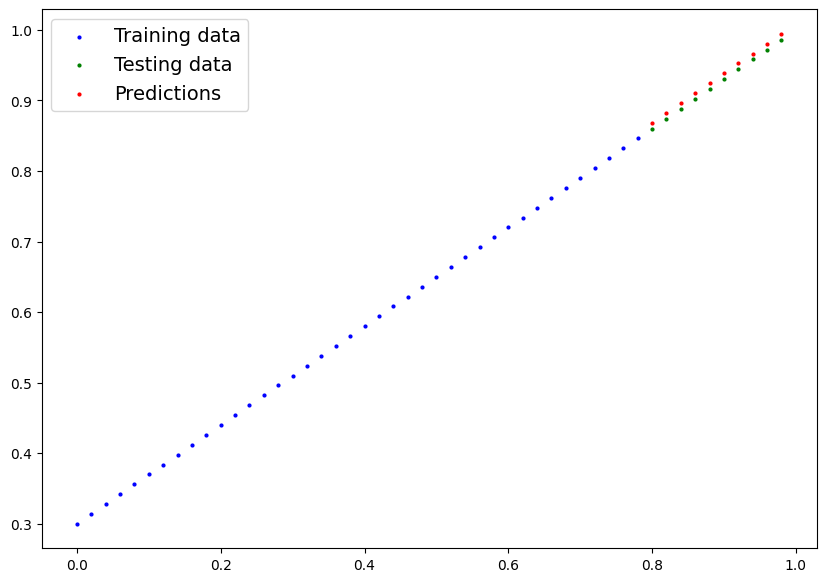

In [ ]:
with torch.inference_mode():
    y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

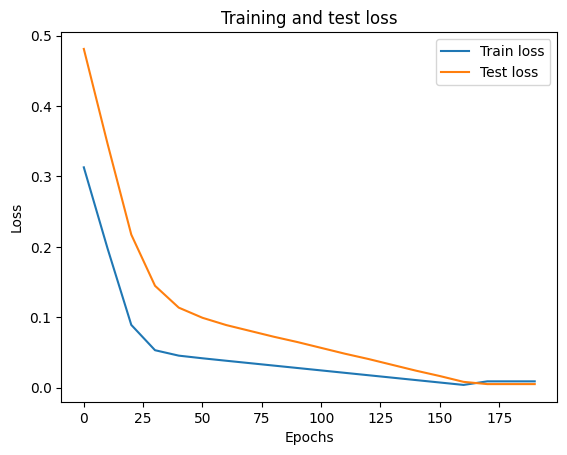

In [ ]:
# ploting the loss curve
# since loss_values contains tensors with grad tracking and they can't be plotted
with torch.inference_mode():
  plt.plot(epochs_count,loss_values,label="Train loss")
  plt.plot(epochs_count,test_loss_values,label="Test loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Training and test loss")
  plt.legend()

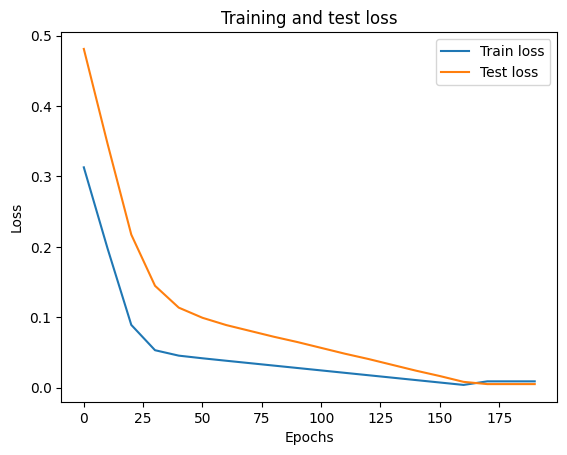

In [ ]:
# alternately we can convert whole list to numpy array
import numpy as np
loss_values = torch.tensor(loss_values).detach().numpy()
test_loss_values = torch.tensor(test_loss_values).detach().numpy()
test_loss_values = np.array(test_loss_values)
plt.plot(epochs_count,loss_values,label="Train loss")
plt.plot(epochs_count,test_loss_values,label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and test loss")
plt.legend()

### Saving a model in PyTorch

There are 3 main methods you should know about for saving and loading models in PyTorch

1. `torch.save()` - allows to save a PyTorch object in Python's pickle format
2. `torch.load()` - allows to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows to load a model's saved state dictionary

PyTorch save and load model - https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
# Saving our PyTorch model
from pathlib import Path

# 1.Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2.Create a model save path
MODEL_NAME = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model.pth


### Loading PyTorch model

Since we saved our model's `state_dict()` rather than the entire model we will create a new instance of our model class and load the saved state dictionary into it.

In [ ]:
# loading our saved model
# remember if you want to retain the original state_dict() of model_0 make a deepcopy of it while saving as any changes by training to model_1.state_dict() wll also change model_0.state_dict() since it's just a reference
model_1 = LinearRegressionModelV1()
model_1.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True))
model_1.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

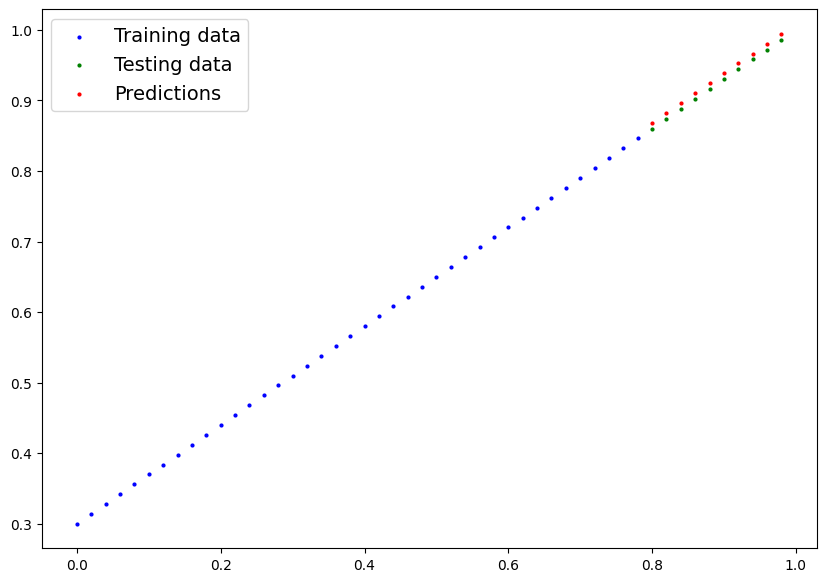

In [ ]:
# make somme predictions using loaded model
model_1.eval()
with torch.inference_mode():
    y_preds1 = model_1(X_test)

plot_predictions(predictions=y_preds1)

In [ ]:
# check if both model's ypred are exactly same
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)

model_1.eval()
with torch.inference_mode():
    y_preds1 = model_1(X_test)

y_preds == y_preds1

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

Let's go back through the steps above and see it all in one place

In [1]:
# Import Pytorch and matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check PyTorch Version
torch.__version__

'2.4.1+cu121'

Create device-agnostic code.

This means if we've got access to GPU, our code will use it (for potentiallly faster computing)

If no GPU we will default to the CPU

In [33]:
# Setup device agnostic course
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [34]:
!nvidia-smi

Sun Oct 13 13:14:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   78C    P0              33W /  70W |    159MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 6.1 Data

In [35]:
# prepare data and turn it into tensors

x = torch.arange(0.04, 1, 0.04).unsqueeze(dim=1)

weight = 0.69
bias = 0.42

y = weight * x + bias

train_split = int(0.8 * len(x))
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

print(f"Training data {len(x_train)}, testing data {len(x_test)}")
print(f"shape of x_train {x_train.shape}, shape of y_train {y_train.shape}")

Training data 19, testing data 5
shape of x_train torch.Size([19, 1]), shape of y_train torch.Size([19, 1])


In [36]:
def plot_predictions(x_train = x_train,
                     y_train = y_train,
                     x_test = x_test,
                     y_test = y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))

    plt.scatter(x_train, y_train, c="g", label="Training data")
    plt.scatter(x_test, y_test, c="b", label="Testing data")

    if predictions is not None:
        plt.scatter(x_test, predictions, c="r", label="Predictions")

    plt.legend()
    plt.show()

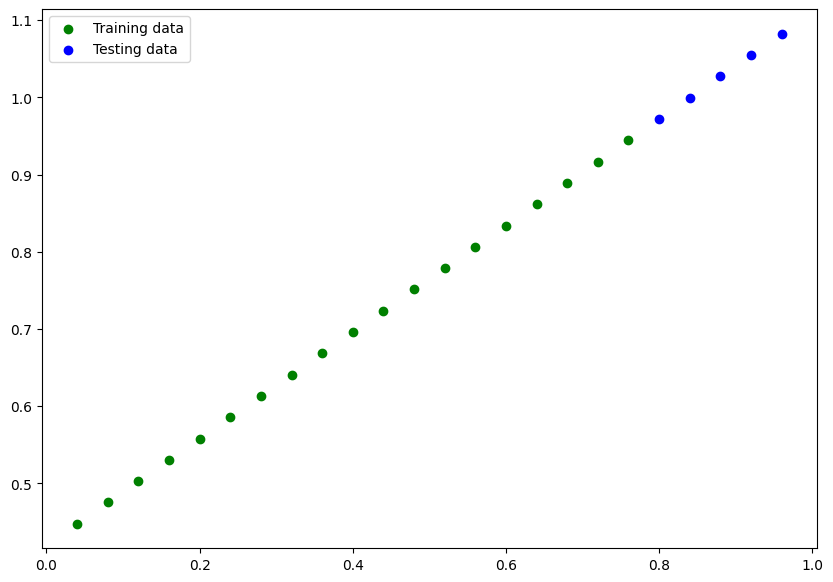

In [37]:
plot_predictions()

### 6.2 Creating Model


In [38]:
class LinerRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parameters
    # called linear layer, linear transform, probing layer, fully connected layer, dense layer
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed for reproducibility
torch.manual_seed(42)

# Create an instance of the model
model_3 = LinerRegressionModelV2()
model_3, model_3.state_dict()

(LinerRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [39]:
# Check the  model current device
next(model_3.parameters()).device

device(type='cpu')

In [40]:
# Set the model to use the target device
model_3.to(device)
next(model_3.parameters()).device

device(type='cuda', index=0)

In [41]:
# make predictions with random weights
# the following will give error since data is on cpu
with torch.inference_mode():
  y_preds = model_3(x_test)

plot_predictions(predictions=y_preds)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [42]:
# move data to the same device as the model that is on GPU
# device agnostic code for data
x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

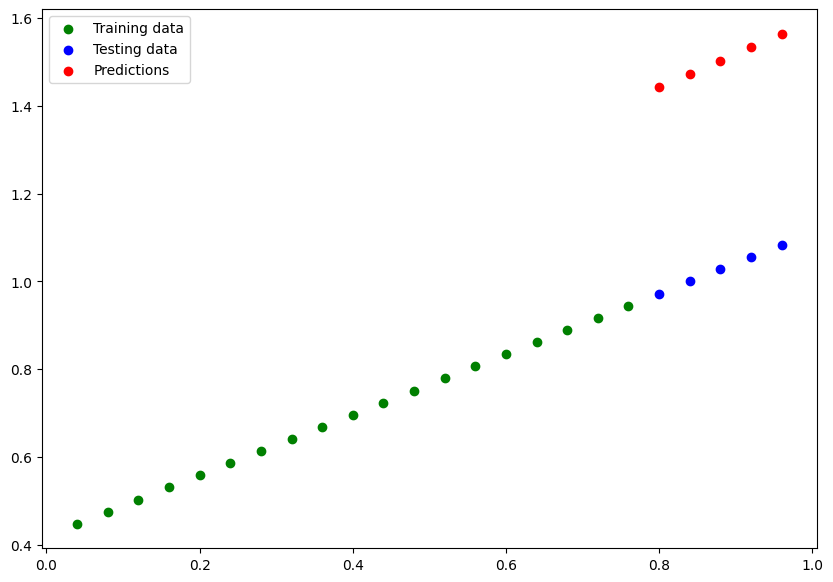

In [43]:
# still getting error since numpy works on cpu and trying to convert to numpy to use in matplotlib
with torch.inference_mode():
  y_preds = model_3(x_test)

x_train_cpu = x_train.detach().clone().to("cpu")
y_train_cpu = y_train.detach().clone().to("cpu")
x_test_cpu = x_test.detach().clone().to("cpu")
y_test_cpu = y_test.detach().clone().to("cpu")

y_preds = y_preds.detach().clone().to("cpu")

plot_predictions(x_train=x_train_cpu,
                 y_train=y_train_cpu,
                 x_test=x_test_cpu,
                 y_test=y_test_cpu,
                 predictions=y_preds)

In [44]:
# Creating loss function and optimizer
loss_fn = nn.L1Loss()

optimiser = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

### 6.3 Creating training and testing loop


In [45]:
epoch = 200
train_loss_list = []
test_loss_list = []

for i in range(epoch):
  model_3.train()
  # forward pass
  y_pred = model_3(x_train)
  # calculate loss
  loss = loss_fn(y_pred, y_train)
  # set optimizer to zero
  optimiser.zero_grad()
  # backward propagation
  loss.backward()
  # optimizer step
  optimiser.step()

  # Testing loop
  model_3.eval()
  with torch.inference_mode():
    test_pred = model_3(x_test)
    test_loss = loss_fn(test_pred, y_test)

  if i % 10 == 0:
    train_loss_list.append(loss)
    test_loss_list.append(test_loss)
    print(f"Epoch: {i} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.43982335925102234 | Test loss: 0.46208181977272034
Epoch: 10 | Loss: 0.3238234221935272 | Test loss: 0.32688185572624207
Epoch: 20 | Loss: 0.20782345533370972 | Test loss: 0.1916818916797638
Epoch: 30 | Loss: 0.0918235257267952 | Test loss: 0.05648190900683403
Epoch: 40 | Loss: 0.013727007433772087 | Test loss: 0.030777037143707275
Epoch: 50 | Loss: 0.010584376752376556 | Test loss: 0.024139631539583206
Epoch: 60 | Loss: 0.007513389922678471 | Test loss: 0.017502261325716972
Epoch: 70 | Loss: 0.00442510237917304 | Test loss: 0.009404683485627174
Epoch: 80 | Loss: 0.0055239140056073666 | Test loss: 0.003252065274864435
Epoch: 90 | Loss: 0.0055239140056073666 | Test loss: 0.003252065274864435
Epoch: 100 | Loss: 0.0055239140056073666 | Test loss: 0.003252065274864435
Epoch: 110 | Loss: 0.0055239140056073666 | Test loss: 0.003252065274864435
Epoch: 120 | Loss: 0.0055239140056073666 | Test loss: 0.003252065274864435
Epoch: 130 | Loss: 0.0055239140056073666 | Test loss: 0.

In [46]:
model_3.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6801]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.4184], device='cuda:0'))])

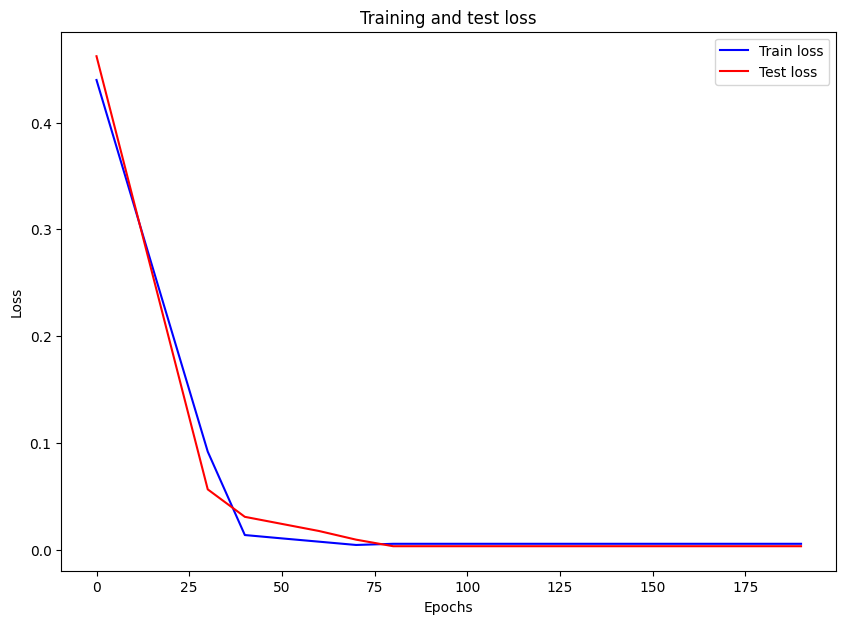

In [47]:
import numpy as np
fig = plt.figure(figsize=(10,7))
epochs = np.arange(0,200, 10)
train_loss_list = torch.Tensor(train_loss_list).detach().numpy()
test_loss_list = torch.Tensor(test_loss_list).detach().numpy()
plt.plot(epochs, train_loss_list, label="Train loss", c="b")
plt.plot(epochs, test_loss_list, label="Test loss", c="r")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and test loss")
plt.legend()

### 6.4 Making and evaluating predictions

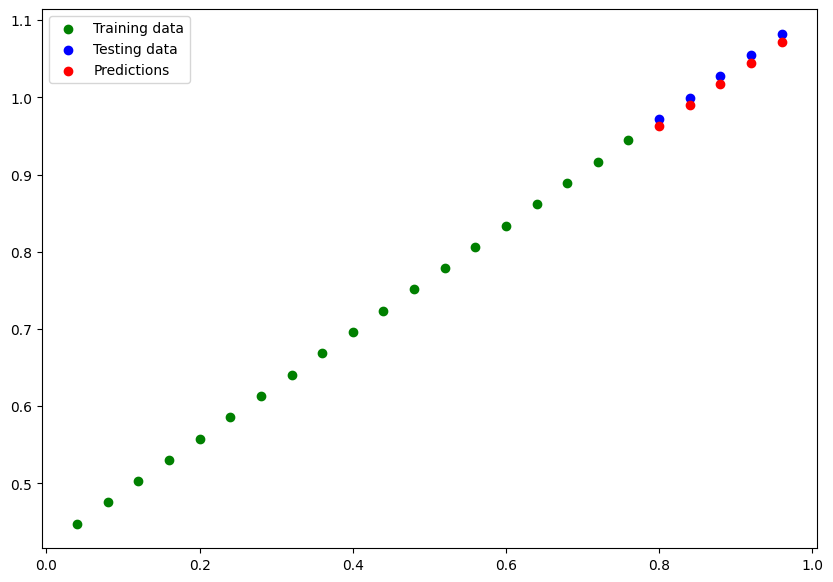

In [48]:
model_3.eval()
with torch.inference_mode():
  y_preds = model_3(x_test)

y_preds = y_preds.detach().clone().to("cpu")

plot_predictions(x_train=x_train_cpu,
                 y_train=y_train_cpu,
                 x_test=x_test_cpu,
                 y_test=y_test_cpu,
                 predictions=y_preds)

### 6.5 Saving and loading a trained model

In [49]:
# Saving our model
from pathlib import Path

# 1.Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
model_name = "01_pytorch_workflow_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / model_name

# save model state dict
torch.save(obj=model_3.state_dict(), f=MODEL_SAVE_PATH)

In [50]:
# Loading the model

# create instance of model
model = LinerRegressionModelV2()

# load the state dict of saved model
model.load_state_dict(torch.load(MODEL_SAVE_PATH, weights_only=True))
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6801]])),
             ('linear_layer.bias', tensor([0.4184]))])

In [52]:
# for device agnostic code put model to device
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [58]:
# Evaluate loaded model
model.eval()
with torch.inference_mode():
  pred = model(x_test)
y_preds = y_preds.to(device)
pred == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Exercises and Extra-curriculum

go to end of the page- https://www.learnpytorch.io/01_pytorch_workflow/